## ASD tsne

In [13]:
import torchvision.models as models
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
                transforms.Resize((224, 168)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.96, 0.96, 0.96], std=[0.1, 0.1, 0.1])])

dataset_val = datasets.ImageFolder("/data/datasets/asd/All_5split/01/val", transform=transform)
dataset_train = datasets.ImageFolder("/data/datasets/asd/All_5split/01/train", transform=transform)
# dataset = dataset_train + dataset_val

data_list_val = dataset_val.make_dataset("/data/datasets/asd/All_5split/01/val", dataset_val.class_to_idx, extensions='jpg')
data_list_train = dataset_train.make_dataset("/data/datasets/asd/All_5split/01/train", dataset_train.class_to_idx, extensions='jpg')
# data_list = data_list_val + data_list_train

model = models.efficientnet_b1(pretrained=False)
model.classifier[1] = torch.nn.Linear(1280, 2)
checkpoint_model = torch.load("/data/ahngeo11/asd/mae-upstream/logs/all-5splits/efficientnet/99-retrain/0/OUT/01/checkpoint-26.pth", map_location='cpu')['model']
model.eval()

msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

/data/ahngeo11/anaconda3/envs/mae/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ahngeo11/anaconda3/envs/mae/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>


In [14]:
asd_train, td_train = [], []
asd_val, td_val = [], []
asd_anns_train, td_anns_train = [], []
asd_anns_val, td_anns_val = [], []
for i in range(len(data_list_train)) : 
    img, label = dataset_train[i]
    feat = model(img.unsqueeze(0), feature_roi=True).detach().cpu()
    if 'ASD' in data_list_train[i][0].split('/')[-2] :
        asd_train.append(feat)
        asd_anns_train.append(data_list_train[i][0])
    else :
        td_train.append(feat)
        td_anns_train.append(data_list_train[i][0])
        
for i in range(len(data_list_val)) : 
    img, label = dataset_val[i]
    feat = model(img.unsqueeze(0), feature_roi=True).detach().cpu()
    if 'ASD' in data_list_val[i][0].split('/')[-2] :
        asd_val.append(feat)
        asd_anns_val.append(data_list_val[i][0])
    else :
        td_val.append(feat)
        td_anns_val.append(data_list_val[i][0])

In [15]:
from sklearn.linear_model import LogisticRegression

total = asd_train + td_train + asd_val + td_val

feats = torch.stack(total)
feats = feats.view(feats.shape[0], feats.shape[2], feats.shape[3], feats.shape[4])
print("before tsne shape : ", feats.shape)

avgpool = torch.nn.AvgPool2d(kernel_size=(7, 6))
feats = avgpool(feats)

feats = feats.reshape((feats.shape[0], -1))
print("before tsne shape : ", feats.shape)

decision_line = LogisticRegression()
decision_line.fit(feats[:80], [0]*40+[1]*40)
w = decision_line.coef_[0]
b = decision_line.intercept_

import numpy as np
# for feat in feats :
    # print(np.sum(w * feat.numpy()) + b)  #! 100%

distance = []
for feat in feats :
    dist = abs(np.sum(w * feat.numpy()) + b) / np.sqrt(np.sum(np.square(w))) 
    distance.append(dist)


before tsne shape :  torch.Size([100, 1280, 7, 6])
before tsne shape :  torch.Size([100, 1280])


before tsne shape :  torch.Size([100, 1280, 7, 6])
before tsne shape :  torch.Size([100, 1280])
after tsne shape :  (100, 50)
after tsne shape :  (100, 2)


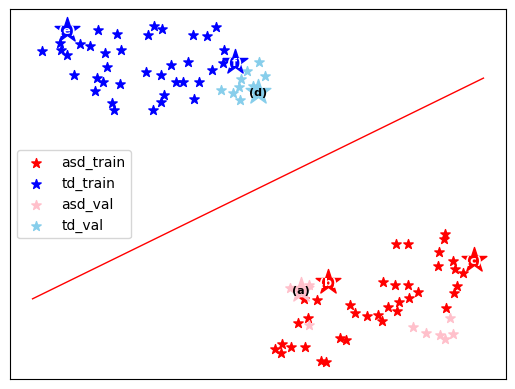

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# total = asd_val + td_val
total = asd_train + td_train + asd_val + td_val

feats = torch.stack(total)
feats = feats.view(feats.shape[0], feats.shape[2], feats.shape[3], feats.shape[4])
print("before tsne shape : ", feats.shape)

avgpool = torch.nn.AvgPool2d(kernel_size=(7, 6))
feats = avgpool(feats)

feats = feats.reshape((feats.shape[0], -1))
print("before tsne shape : ", feats.shape)

feats = feats.numpy()
scaler = MinMaxScaler()
feats = scaler.fit_transform(feats)

pca = PCA(50)
feats = pca.fit_transform(feats)

print("after tsne shape : ", feats.shape)


tsne = TSNE(n_components=2, random_state=777, perplexity=10)
data_tsne = tsne.fit_transform(feats)

print("after tsne shape : ", data_tsne.shape)

labels = [0] * 40 + [1] * 40 + [6] * 10 + [7] * 10 
# labels = [6] * 10 + [7] * 10 

#? plot the results with labels
cmap = plt.get_cmap('Paired')
plt.scatter(data_tsne[:40, 0], data_tsne[:40, 1], c='red',label='asd_train', s=50, marker='*')
plt.scatter(data_tsne[40:80, 0], data_tsne[40:80, 1], c='blue', label='td_train', s=50, marker='*')
plt.scatter(data_tsne[80:90, 0], data_tsne[80:90, 1], c='pink', label='asd_val', s=50, marker='*')
plt.scatter(data_tsne[90:, 0], data_tsne[90:, 1], c='skyblue', label='td_val', s=50, marker='*')

# for i in range(len(data_tsne)) :
#     x = data_tsne[i, 0]
#     y = data_tsne[i, 1]
#     plt.text(x, y, str(i), fontsize=8)

x, y = data_tsne[3]
plt.scatter(x, y, c='red', s=350, marker='*')
plt.text(x, y, "(c)", fontsize=8, va='center', ha='center', fontweight='heavy', color='white')
x, y = data_tsne[8]
plt.scatter(x, y, c='red', s=350, marker='*')
plt.text(x, y, "(b)", fontsize=8, va='center', ha='center', fontweight='heavy', color='white')
x, y = data_tsne[80]
plt.scatter(x, y, c='pink', s=350, marker='*')
plt.text(x, y, "(a)", fontsize=8, va='center', ha='center', fontweight='heavy')
x, y = data_tsne[45]
plt.scatter(x, y, c='blue', s=350, marker='*')
plt.text(x, y, "(f)", fontsize=8, va='center', ha='center', fontweight='heavy', color='white')
x, y = data_tsne[47]
plt.scatter(x, y, c='blue', s=350, marker='*')
plt.text(x, y, "(e)", fontsize=8, va='center', ha='center', fontweight='heavy', color='white')
x, y = data_tsne[99]
plt.scatter(x, y, c='skyblue', s=350, marker='*')
plt.text(x, y, "(d)", fontsize=8, va='center', ha='center', fontweight='heavy')
    

#! decision line
from sklearn.linear_model import LogisticRegression

decision_line = LogisticRegression()
decision_line.fit(data_tsne[:80], [0]*40+[1]*40)
# decision_line.fit(feats[:80], [0]*40+[1]*40)
w = decision_line.coef_[0]
b = decision_line.intercept_

slope = -w[0] / w[1]
intercept = -b / w[1]

import numpy as np
x_min, x_max = data_tsne[:, 0].min() - 1, data_tsne[:, 0].max() + 1
# x_min, x_max = feats[:, 0].min() - 1, feats[:, 0].max() + 1
x_line = np.linspace(x_min, x_max, 100)


y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', linestyle='-', linewidth=1)

plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

#######################
#! second plot for not-texted version

# plt.scatter(data_tsne[:40, 0], data_tsne[:40, 1], c='red',label='asd_train', s=50, marker='*')
# plt.scatter(data_tsne[40:80, 0], data_tsne[40:80, 1], c='blue', label='td_train', s=50, marker='*')
# plt.scatter(data_tsne[80:90, 0], data_tsne[80:90, 1], c='pink', label='asd_val', s=50, marker='*')
# plt.scatter(data_tsne[90:, 0], data_tsne[90:, 1], c='skyblue', label='td_val', s=50, marker='*')

# plt.plot(x_line, y_line, color='red', linestyle='-', linewidth=1)

# plt.legend()
# plt.show()

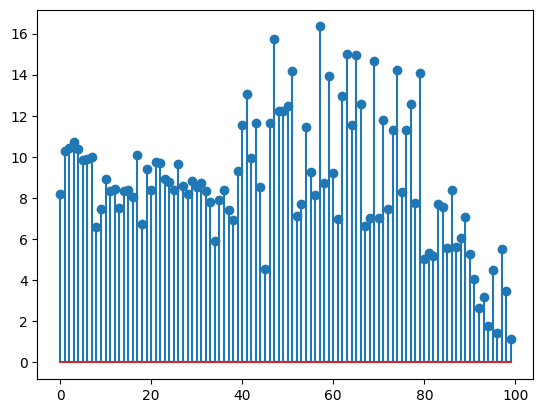

array([40, 42, 41, 45, 47, 34, 48,  8, 18, 38, 49, 37,  9, 13, 44, 43, 33,
       35, 16, 28,  0, 11, 32, 14, 25, 15, 46, 20, 36, 12, 30, 27, 31, 24,
       29, 23, 10, 39, 19, 26, 22, 21,  5,  6,  7, 17,  1,  4,  2,  3])

In [8]:
# plt.stem(np.arange(100)[80:], np.array(distance[80:]).reshape(-1))
#! visualize for distance between decision line and each sample
plt.stem(np.arange(100), np.array(distance).reshape(-1))
plt.show()

# np.argsort(np.array(distance[80:]).reshape(-1))
sorted_idx = np.argsort(np.array(distance[:40]+distance[80:90]).reshape(-1))
sorted_idx

In [22]:
td_anns_train[5]

'/data/datasets/asd/All_5split/01/train/TD/B-2-s1.jpg'

In [ ]:
total = asd_train + td_train + asd_val + td_val

feats = torch.stack(total)
feats = feats.view(feats.shape[0], feats.shape[2], feats.shape[3], feats.shape[4])

avgpool = torch.nn.AdaptiveAvgPool2d(1)
feats = avgpool(feats)

feats = feats.reshape((feats.shape[0], -1))

#! check for model's test acc
for i, feat in enumerate(feats) :
    print(i, torch.argmax(model.classifier(torch.FloatTensor(feat))))

In [ ]:
decision_line = LogisticRegression()
decision_line.fit(feats[:80], [0]*40+[1]*40)
w = decision_line.coef_[0]
b = decision_line.intercept_

slope = -w[0] / w[1]
intercept = -b / w[1]

#! check for scikit-learn linear model's prediction
pred = decision_line.predict(feats)
for i, p in enumerate(pred) :
    print(i, p)

## ASD_Part

In [ ]:
import torchvision.models as models
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
                transforms.Resize((224, 168)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.96, 0.96, 0.96], std=[0.1, 0.1, 0.1])])

dataset_val = datasets.ImageFolder("/data/datasets/asd/All_5split/01/val", transform=transform)
dataset_train = datasets.ImageFolder("/data/datasets/asd/All_5split/01/train", transform=transform)
# dataset = dataset_train + dataset_val

data_list_val = dataset_val.make_dataset("/data/datasets/asd/All_5split/01/val", dataset_val.class_to_idx, extensions='jpg')
data_list_train = dataset_train.make_dataset("/data/datasets/asd/All_5split/01/train", dataset_train.class_to_idx, extensions='jpg')
# data_list = data_list_val + data_list_train

model = models.efficientnet_b1(pretrained=False)
model.classifier[1] = torch.nn.Linear(1280, 2)
checkpoint_model = torch.load("/data/ahngeo11/asd/mae-upstream/logs/all-5splits/efficientnet/99-retrain/0/OUT/01/checkpoint-26.pth", map_location='cpu')['model']
model.eval()

msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

## AI-HUB

In [1]:
from torchvision import datasets, transforms
from shapley.transform import ThresholdTransform
from tqdm import tqdm
import torchvision.models as models
import torch
from shapley.dataset import AI_HUB

transform = transforms.Compose([
                transforms.Resize((224, 168)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.98, 0.98, 0.98],
                                     std=[0.065, 0.065, 0.065])])

# transform = transforms.Compose([transforms.Resize((224,168)),
                                # transforms.Grayscale(3),
                                # transforms.ToTensor(),
                                # ThresholdTransform(240),
                                # transforms.Normalize(mean=[0.98, 0.98, 0.98],
                                    # std=[0.065, 0.065, 0.065])])

dataset_val = AI_HUB("/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01", "/data/datasets/asd/ai-hub/ai_hub_sketch_json", False)
data_list_val = dataset_val.dataset.make_dataset("/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val", dataset_val.dataset.class_to_idx, extensions="jpg")
dataset_train = AI_HUB("/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01", "/data/datasets/asd/ai-hub/ai_hub_sketch_json", True)
data_list_train = dataset_train.dataset.make_dataset("/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/train", dataset_train.dataset.class_to_idx, extensions="jpg")

# dataset_val = datasets.ImageFolder("/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val", transform=transform)
# data_list_val = dataset_val.make_dataset("/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val", dataset_val.class_to_idx, extensions='jpg')
# dataset_train = datasets.ImageFolder("/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/train", transform=transform)
# data_list_train = dataset_val.make_dataset("/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/train", dataset_train.class_to_idx, extensions='jpg')

Compose(
    Resize(size=(224, 168), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.98, 0.98, 0.98], std=[0.065, 0.065, 0.065])
)
img_root_dir :  /data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val
json_root_dir :  /data/datasets/asd/ai-hub/ai_hub_sketch_json
extension :  jpg
class_ind :  {'m': 0, 'w': 1}
Compose(
    Resize(size=(224, 168), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.98, 0.98, 0.98], std=[0.065, 0.065, 0.065])
)
img_root_dir :  /data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/train
json_root_dir :  /data/datasets/asd/ai-hub/ai_hub_sketch_json
extension :  jpg
class_ind :  {'m': 0, 'w': 1}


In [2]:
train_m_len, train_w_len = 0, 0
for line in data_list_train :
    if line[1] == 0 :
        train_m_len += 1
    else :
        train_w_len += 1
val_m_len, val_w_len = 0, 0
for line in data_list_val :
    if line[1] == 0 :
        val_m_len += 1
    else :
        val_w_len += 1    

In [3]:
print(train_m_len)
print(train_w_len)
print(val_m_len)
print(val_w_len)

11200
11200
1400
1400


In [4]:
import random
random.seed(777)
torch.manual_seed(777)
indices = [i for i in range(train_m_len)]
train_m_indices = random.sample(indices, 250)
indices = [i for i in range(train_w_len)]
train_w_indices = random.sample(indices, 250)
indices = [i for i in range(val_m_len)]
val_m_indices = random.sample(indices, 50)
indices = [i for i in range(val_w_len)]
val_w_indices = random.sample(indices, 50)

dataset_train_m = [dataset_train[i] for i in train_m_indices]
dataset_train_w = [dataset_train[i + train_m_len] for i in train_w_indices]
dataset_val_m = [dataset_val[i] for i in val_m_indices]
dataset_val_w = [dataset_val[i + val_m_len] for i in val_w_indices]

data_list_train_m = [data_list_train[i] for i in train_m_indices]
data_list_train_w = [data_list_train[i + train_m_len] for i in train_w_indices]
data_list_val_m = [data_list_val[i] for i in val_m_indices]
data_list_val_w = [data_list_val[i + val_m_len] for i in val_w_indices]

In [43]:
model = models.efficientnet_b1(pretrained=False)
model.classifier[1] = torch.nn.Linear(1280, 2)
checkpoint_model = torch.load("/data/ahngeo11/asd/mae-upstream/logs/ai-hub/224-168-own-norm/30e/1e-2/OUT/01/checkpoint-26.pth", map_location='cpu')['model']

msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

model.eval()

m_train, m_anns_train = [], []
w_train, w_anns_train = [], []
for i in tqdm(range(len(data_list_train_m))) : 
    img, _ = dataset_train_m[i]
    feat = model(img.unsqueeze(0), feature_roi=True)
    m_train.append(feat)
    m_anns_train.append(data_list_train_m[i][0])
for i in tqdm(range(len(data_list_train_w))) : 
    img, _ = dataset_train_w[i]
    feat = model(img.unsqueeze(0), feature_roi=True)
    w_train.append(feat)
    w_anns_train.append(data_list_train_w[i][0])
        
m_val, m_anns_val = [], []
w_val, w_anns_val = [], []
for i in tqdm(range(len(data_list_val_m))) : 
    img, _ = dataset_val_m[i]
    feat = model(img.unsqueeze(0), feature_roi=True)
    m_val.append(feat)
    m_anns_val.append(data_list_val_m[i][0])
for i in tqdm(range(len(data_list_val_w))) : 
    img, _ = dataset_val_w[i]
    feat = model(img.unsqueeze(0), feature_roi=True)
    w_val.append(feat)
    w_anns_val.append(data_list_val_w[i][0])

/data/ahngeo11/anaconda3/envs/mae/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ahngeo11/anaconda3/envs/mae/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 40.58it/s]


In [72]:
total = m_train + w_train + m_val + w_val

feats = torch.stack(total)
feats = feats.view(feats.shape[0], feats.shape[2], feats.shape[3], feats.shape[4])

avgpool = torch.nn.AdaptiveAvgPool2d(1)
feats = avgpool(feats)

feats = feats.reshape((feats.shape[0], -1))
print(feats.shape)

#! check for model's test acc
k = 0
for i, feat in enumerate([feats[i] for i in range(500, 550)]) :
    if int(torch.argmax(model.classifier(feat))) == 1 :
        print(i)
        k += 1
    # print(i, torch.argmax(model.classifier(feat)))
k/250

torch.Size([600, 1280])
29
30


0.008

before tsne shape :  torch.Size([600, 1280, 7, 6])
before tsne shape :  torch.Size([600, 1280])
after tsne shape :  (600, 50)
after tsne shape :  (600, 2)


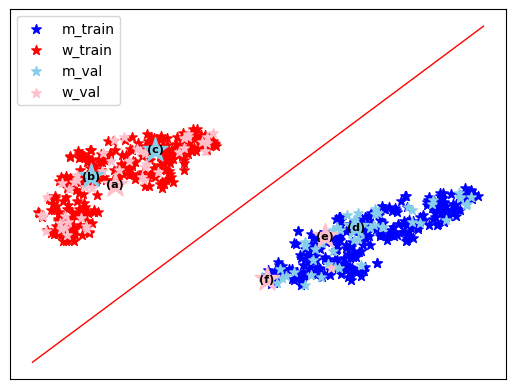

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

total = m_train + w_train + m_val + w_val

feats = torch.stack(total)
feats = feats.view(feats.shape[0], feats.shape[2], feats.shape[3], feats.shape[4])
print("before tsne shape : ", feats.shape)

# avgpool = torch.nn.AvgPool2d(kernel_size=(7, 6))
avgpool = torch.nn.AdaptiveAvgPool2d(1)
feats = avgpool(feats)

feats = feats.reshape((feats.shape[0], -1))
print("before tsne shape : ", feats.shape)

feats = feats.detach().numpy()
scaler = MinMaxScaler()
feats = scaler.fit_transform(feats)

pca = PCA(50)
feats = pca.fit_transform(feats)

print("after tsne shape : ", feats.shape)


tsne = TSNE(n_components=2, random_state=777)   # , perplexity=20
data_tsne = tsne.fit_transform(feats)

print("after tsne shape : ", data_tsne.shape)

# labels = [0] * 250 + [1] * 250 + [6] * 50 + [7] * 50 
# labels = [6] * 10 + [7] * 10 

#? plot the results with labels
cmap = plt.get_cmap('Paired')
plt.scatter(data_tsne[:250, 0], data_tsne[:250, 1], c='blue',label='m_train', s=50, marker='*')
plt.scatter(data_tsne[250:500, 0], data_tsne[250:500, 1], c='red', label='w_train', s=50, marker='*')
plt.scatter(data_tsne[500:550, 0], data_tsne[500:550, 1], c='skyblue', label='m_val', s=50, marker='*')
plt.scatter(data_tsne[550:, 0], data_tsne[550:, 1], c='pink', label='w_val', s=50, marker='*')

for i in range(500, 550) :
    x = data_tsne[i, 0]
    y = data_tsne[i, 1]
    # plt.text(x, y, str(i), fontsize=8)

#! decision line
from sklearn.linear_model import LogisticRegression

decision_line = LogisticRegression()
decision_line.fit(data_tsne[:500], [0]*250+[1]*250)
w = decision_line.coef_[0]
b = decision_line.intercept_

slope = -w[0] / w[1]
intercept = -b / w[1]

import numpy as np
x_min, x_max = data_tsne[:, 0].min() - 1, data_tsne[:, 0].max() + 1
x_line = np.linspace(x_min, x_max, 100)


y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', linestyle='-', linewidth=1)

x, y = data_tsne[556]
plt.scatter(x, y, c='pink', s=350, marker='*')
plt.text(x, y, "(a)", fontsize=8, va='center', ha='center', fontweight='heavy')
x, y = data_tsne[529]
plt.scatter(x, y, c='skyblue', s=350, marker='*')
plt.text(x, y, "(b)", fontsize=8, va='center', ha='center', fontweight='heavy')
x, y = data_tsne[530]
plt.scatter(x, y, c='skyblue', s=350, marker='*')
plt.text(x, y, "(c)", fontsize=8, va='center', ha='center', fontweight='heavy')

x, y = data_tsne[521]
plt.scatter(x, y, c='skyblue', s=350, marker='*')
plt.text(x, y, "(d)", fontsize=8, va='center', ha='center', fontweight='heavy')
x, y = data_tsne[553]
plt.scatter(x, y, c='pink', s=350, marker='*')
plt.text(x, y, "(e)", fontsize=8, va='center', ha='center', fontweight='heavy')
# x, y = data_tsne[563]
# plt.scatter(x, y, c='pink', s=350, marker='*')
# plt.text(x, y, "(d)", fontsize=8, va='center', ha='center', fontweight='heavy')
x, y = data_tsne[595]
plt.scatter(x, y, c='pink', s=350, marker='*')
plt.text(x, y, "(f)", fontsize=8, va='center', ha='center', fontweight='heavy')

plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()


In [78]:
print(data_list_val_w[556-550])
print(data_list_val_m[529-500])
print(data_list_val_m[530-500])
print(data_list_val_m[521-500])
print(data_list_val_w[553-550])
print(data_list_val_w[595-550])

('/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val/w/w_12_m_01071.jpg', 1)
('/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val/m/m_9_w_03510.jpg', 0)
('/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val/m/m_10_w_05188.jpg', 0)
('/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val/m/m_12_w_02052.jpg', 0)
('/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val/w/w_13_w_11676.jpg', 1)
('/data/datasets/asd/ai-hub/ai_hub_sketch_mw/01/val/w/w_11_m_03286.jpg', 1)


In [7]:
def translation_and_resize(coords, origin, crop_size, resize=(224, 168)) :
    xmin, ymin, xmax, ymax = coords
    xmin = xmin - origin[0] if xmin - origin[0] > 0 else 0
    ymin = ymin - origin[1] if ymin - origin[1] > 0 else 0
    xmax = xmax - origin[0] if xmax - origin[0] < crop_size[0] else crop_size[0] 
    ymax = ymax - origin[1] if ymax - origin[1] < crop_size[1] else crop_size[1] 
    
    xmin, ymin = int(xmin/crop_size[0] * resize[1]), int(ymin/crop_size[1] * resize[0])
    xmax, ymax = int(xmax/crop_size[0] * resize[1]), int(ymax/crop_size[1] * resize[0])
    
    return xmin, ymin, xmax, ymax

In [49]:
import json
from torchvision.ops import RoIAlign
import os

roi = RoIAlign(output_size=(1,1), spatial_scale=0.03125, sampling_ratio=2)

m_results_train, w_results_train = [], []
m_results_val, w_results_val = [], []

PART = '입'

for anns, feats, results in zip([m_anns_train, w_anns_train, m_anns_val, w_anns_val], [m_train, w_train, m_val, w_val], [m_results_train, w_results_train, m_results_val, w_results_val]) :
    for ann, feat in zip(anns, feats) :
        # ann_path = ann.split('/')[-2] + "/" + ann.split('/')[-1].replace(".jpg", ".json")
        ann_path = ann.split('/')[-1].replace(".jpg", ".json")
        with open(os.path.join("/data/datasets/asd/ai-hub/ai_hub_sketch_json", ann_path), 'r') as f :
            data = json.load(f)["annotations"]
        h, w = 1280, 1280
        # h, w = data['imageHeight'], data['imageWidth']
        
        ann_person = data['bbox'][0]
        assert ann_person['label'] == '사람전체'
        origin = (ann_person['x'], ann_person['y'])
        crop_size = (ann_person['w'], ann_person['h'])
        
        k=0
        for obj_ann in data['bbox'] :
            if obj_ann['label'] == PART and k == 0:
                p11, p12, p21, p22 = obj_ann['x'], obj_ann['y'], obj_ann['x']+obj_ann['w'], obj_ann['y'],
                
                xmin, ymin, xmax, ymax = obj_ann['x'], obj_ann['y'], obj_ann['x']+obj_ann['w'], obj_ann['y']+obj_ann['h']
                #* translation to person crop coords 
                xmin, ymin, xmax, ymax = translation_and_resize([xmin, ymin, xmax, ymax], origin, crop_size)
                
                roi_feat = roi(feat, torch.FloatTensor([0, xmin, ymin, xmax, ymax]).reshape(1, 5))
                results.append(roi_feat)
                k=1


before tsne shape :  torch.Size([600, 1280, 1, 1])
before tsne shape :  torch.Size([600, 1280])
after tsne shape :  (600, 50)
after tsne shape :  (600, 2)


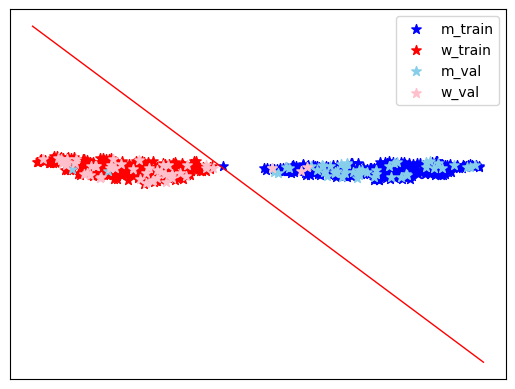

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

total = m_results_train + w_results_train + m_results_val + w_results_val

feats = torch.stack(total)
feats = feats.view(feats.shape[0], feats.shape[2], feats.shape[3], feats.shape[4])
print("before tsne shape : ", feats.shape)

# avgpool = torch.nn.AvgPool2d(kernel_size=(7, 6))
avgpool = torch.nn.AdaptiveAvgPool2d(1)
feats = avgpool(feats)

feats = feats.reshape((feats.shape[0], -1))
print("before tsne shape : ", feats.shape)

feats = feats.detach().numpy()
scaler = MinMaxScaler()
feats = scaler.fit_transform(feats)

pca = PCA(50)
feats = pca.fit_transform(feats)

print("after tsne shape : ", feats.shape)


tsne = TSNE(n_components=2, random_state=777)   # , perplexity=20
data_tsne = tsne.fit_transform(feats)

print("after tsne shape : ", data_tsne.shape)


#? plot the results with labels
cmap = plt.get_cmap('Paired')
plt.scatter(data_tsne[:250, 0], data_tsne[:250, 1], c='blue',label='m_train', s=50, marker='*')
plt.scatter(data_tsne[250:500, 0], data_tsne[250:500, 1], c='red', label='w_train', s=50, marker='*')
plt.scatter(data_tsne[500:550, 0], data_tsne[500:550, 1], c='skyblue', label='m_val', s=50, marker='*')
plt.scatter(data_tsne[550:, 0], data_tsne[550:, 1], c='pink', label='w_val', s=50, marker='*')

for i in range(500, 550) :
    x = data_tsne[i, 0]
    y = data_tsne[i, 1]
    # plt.text(x, y, str(i), fontsize=8)

#! decision line
from sklearn.linear_model import LogisticRegression

decision_line = LogisticRegression()
decision_line.fit(data_tsne[:500], [0]*250+[1]*250)
w = decision_line.coef_[0]
b = decision_line.intercept_

slope = -w[0] / w[1]
intercept = -b / w[1]

import numpy as np
x_min, x_max = data_tsne[:, 0].min() - 1, data_tsne[:, 0].max() + 1
x_line = np.linspace(x_min, x_max, 100)


y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', linestyle='-', linewidth=1)

# x, y = data_tsne[556]
# plt.scatter(x, y, c='pink', s=350, marker='*')
# plt.text(x, y, "(a)", fontsize=8, va='center', ha='center', fontweight='heavy')
# x, y = data_tsne[529]
# plt.scatter(x, y, c='skyblue', s=350, marker='*')
# plt.text(x, y, "(b)", fontsize=8, va='center', ha='center', fontweight='heavy')
# x, y = data_tsne[530]
# plt.scatter(x, y, c='skyblue', s=350, marker='*')
# plt.text(x, y, "(c)", fontsize=8, va='center', ha='center', fontweight='heavy')

# x, y = data_tsne[521]
# plt.scatter(x, y, c='skyblue', s=350, marker='*')
# plt.text(x, y, "(d)", fontsize=8, va='center', ha='center', fontweight='heavy')
# x, y = data_tsne[553]
# plt.scatter(x, y, c='pink', s=350, marker='*')
# plt.text(x, y, "(e)", fontsize=8, va='center', ha='center', fontweight='heavy')
# # x, y = data_tsne[563]
# # plt.scatter(x, y, c='pink', s=350, marker='*')
# # plt.text(x, y, "(d)", fontsize=8, va='center', ha='center', fontweight='heavy')
# x, y = data_tsne[595]
# plt.scatter(x, y, c='pink', s=350, marker='*')
# plt.text(x, y, "(f)", fontsize=8, va='center', ha='center', fontweight='heavy')

plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()


## Stanford Car

In [1]:
import torchvision.models as models
import torch
from torchvision import datasets, transforms
from shapley.dataset import Stanford_car_with_type
from tqdm import tqdm
import os

transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_val = Stanford_car_with_type("/data/datasets/stanford_car", transform=transform, is_train=False)
dataset_train = Stanford_car_with_type("/data/datasets/stanford_car", transform=transform, is_train=True)
# dataset = dataset_train + dataset_val

data_list_val = [os.path.join("/data/datasets/stanford_car/test/", elem) for elem in dataset_val.image_list]
data_list_train = [os.path.join("/data/datasets/stanford_car/train/", elem) for elem in dataset_train.image_list]
# data_list = data_list_val + data_list_train

model = models.efficientnet_b1(pretrained=False)
model.classifier[1] = torch.nn.Linear(1280, 9)
checkpoint_model = torch.load("/data/ahngeo11/asd/stanford-car-best.pth", map_location='cpu')['model']

msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)


/data/ahngeo11/anaconda3/envs/mae/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ahngeo11/anaconda3/envs/mae/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>


In [2]:
dataset_train_sorted = dict()
for i in range(9) :
    dataset_train_sorted[i] = []
dataset_val_sorted = dict()
for i in range(9) :
    dataset_val_sorted[i] = []
data_list_train_sorted = dict()
for i in range(9) :
    data_list_train_sorted[i] = []
data_list_val_sorted = dict()
for i in range(9) :
    data_list_val_sorted[i] = []

for i in tqdm(range(len(data_list_train))) :
    label = dataset_train.label_list[i]
    dataset_train_sorted[label].append(dataset_train[i])
    data_list_train_sorted[label].append(data_list_train[i])
for i in tqdm(range(len(data_list_val))) :
    label = dataset_val.label_list[i]
    dataset_val_sorted[label].append(dataset_val[i])
    data_list_val_sorted[label].append(data_list_val[i])

100%|██████████| 8025/8025 [05:02<00:00, 26.51it/s]


In [13]:
val, anns_val = [], []

k = 0
for i in tqdm(range(len(data_list_val))) : 
    img, label = dataset_val[i]
    feat = model(img.unsqueeze(0))
    if int(torch.argmax(feat)) == label :
        k += 1
k/len(data_list_val)
    
    # feat = model(img.unsqueeze(0), feature_roi=True)
    # val.append(feat)
    # anns_val.append(data_list_val[i])

100%|██████████| 8025/8025 [04:36<00:00, 29.03it/s]


0.8159501557632399

In [3]:
model.eval()
model.cuda()

train, anns_train = [], []

k = 0
for i in tqdm(range(len(data_list_train))) : 
    img, label = dataset_train[i]
    feat = model(img.unsqueeze(0).cuda()).detach().cpu()
    if int(torch.argmax(feat)) == label :
        k += 1
k/len(data_list_train)
    
    # feat = model(img.unsqueeze(0), feature_roi=True)
    # val.append(feat)
    # anns_val.append(data_list_val[i])

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
total = m_train + w_train + m_val + w_val

feats = torch.stack(total)
feats = feats.view(feats.shape[0], feats.shape[2], feats.shape[3], feats.shape[4])

avgpool = torch.nn.AdaptiveAvgPool2d(1)
feats = avgpool(feats)

feats = feats.reshape((feats.shape[0], -1))
print(feats.shape)

#! check for model's test acc
k = 0
for i, feat in enumerate([feats[i] for i in range(500, 550)]) :
    if int(torch.argmax(model.classifier(feat))) == 1 :
        print(i)
        k += 1
    # print(i, torch.argmax(model.classifier(feat)))
k/250